Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [1]:
pip install pymystem3

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
import re
%matplotlib inline

In [33]:
# additional libraries
from pymystem3 import Mystem
m = Mystem()

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
wiki = open('/content/drive/MyDrive/wiki_data.txt').read().split('\n')

In [36]:
# здесь добавлена лемматизация
def preprocess(text):
    lemmed = ''.join(m.lemmatize(text))
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [37]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [38]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [39]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [40]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [41]:
vocab_size = len(id2word)

# ОБУЧЕНИЕ С Negative sampling


In [42]:
# skip gram
def gen_batches_sg(sentences, window = 7, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [43]:
# cbow
def gen_batches_cbow(sentences, window = 7, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [44]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
model.fit(gen_batches_sg(sentences[:19000], window=5),
          validation_data=gen_batches_sg(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=7)

Epoch 1/7
10000/10000 [==============================] - 94s 9ms/step - loss: 0.4576 - accuracy: 0.7894 - val_loss: 0.4599 - val_accuracy: 0.7943
Epoch 2/7
10000/10000 [==============================] - 68s 7ms/step - loss: 0.4090 - accuracy: 0.8184 - val_loss: 0.4134 - val_accuracy: 0.8183
Epoch 3/7
10000/10000 [==============================] - 69s 7ms/step - loss: 0.3940 - accuracy: 0.8254 - val_loss: 0.3739 - val_accuracy: 0.8345
Epoch 4/7
10000/10000 [==============================] - 65s 7ms/step - loss: 0.3798 - accuracy: 0.8318 - val_loss: 0.3680 - val_accuracy: 0.8443
Epoch 5/7
10000/10000 [==============================] - 69s 7ms/step - loss: 0.3645 - accuracy: 0.8389 - val_loss: 0.3875 - val_accuracy: 0.8285
Epoch 6/7
10000/10000 [==============================] - 67s 7ms/step - loss: 0.3636 - accuracy: 0.8390 - val_loss: 0.3752 - val_accuracy: 0.8333
Epoch 7/7
10000/10000 [==============================] - 66s 7ms/step - loss: 0.3480 - accuracy: 0.8464 - val_loss: 0.3570 -

In [46]:
SG_embeddings = model.layers[2].get_weights()[0]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


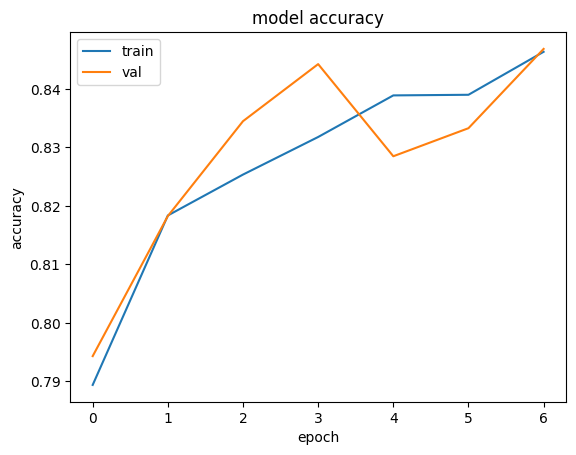

In [47]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
most_similar('мама', SG_embeddings)

['мама',
 'девушка',
 'молодая',
 'сказала',
 'моя',
 'тебя',
 'думает',
 'ты',
 'салли',
 'дженнифер']

In [50]:
most_similar('жизнь', SG_embeddings)

['жизнь',
 'семью',
 'моя',
 'хотят',
 'убивает',
 'политику',
 'знает',
 'мне',
 'уехать',
 'самоубийством']

In [51]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [53]:
model.fit(gen_batches_cbow(sentences[:19000], window=5),
          validation_data=gen_batches_cbow(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=7)

Epoch 1/7
5000/5000 [==============================] - 82s 16ms/step - loss: 0.3625 - accuracy: 0.8414 - val_loss: 0.3093 - val_accuracy: 0.8731
Epoch 2/7
5000/5000 [==============================] - 50s 10ms/step - loss: 0.2750 - accuracy: 0.8852 - val_loss: 0.2574 - val_accuracy: 0.8924
Epoch 3/7
5000/5000 [==============================] - 47s 9ms/step - loss: 0.2278 - accuracy: 0.9063 - val_loss: 0.2737 - val_accuracy: 0.8854
Epoch 4/7
5000/5000 [==============================] - 45s 9ms/step - loss: 0.1938 - accuracy: 0.9219 - val_loss: 0.2426 - val_accuracy: 0.9041
Epoch 5/7
5000/5000 [==============================] - 45s 9ms/step - loss: 0.1705 - accuracy: 0.9328 - val_loss: 0.2945 - val_accuracy: 0.8878
Epoch 6/7
5000/5000 [==============================] - 46s 9ms/step - loss: 0.1563 - accuracy: 0.9398 - val_loss: 0.3125 - val_accuracy: 0.8836
Epoch 7/7
5000/5000 [==============================] - 47s 9ms/step - loss: 0.1392 - accuracy: 0.9484 - val_loss: 0.2713 - val_accurac

In [54]:
cbow_embeddings = model.layers[2].get_weights()[0]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


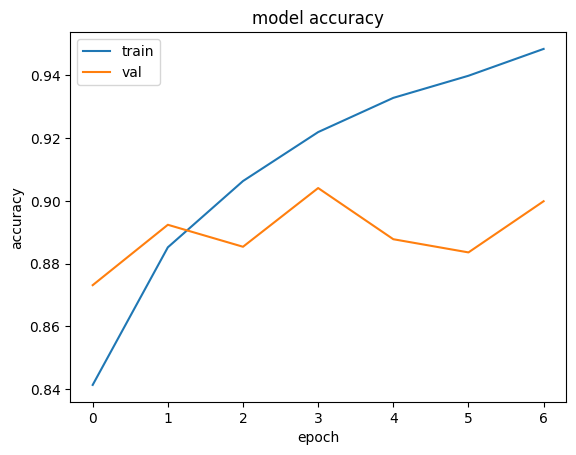

In [55]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
most_similar('мама', cbow_embeddings)

['мама',
 '«ты',
 'лиззи',
 'молодая',
 'александровна',
 'подруга',
 'петровна',
 'сказала',
 'урождённая',
 'нина']

In [57]:
most_similar('жизнь', cbow_embeddings)

['жизнь',
 'деятельность',
 'свободу',
 'историю',
 'взгляды',
 'она',
 'церковь',
 'веру',
 'прошлое',
 'мне']


# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [58]:
pip install gensim

In [59]:
import gensim
from pymystem3 import Mystem
m = Mystem()

In [64]:
texts = [preprocess(text) for text in wiki]

In [65]:
w2v = gensim.models.Word2Vec(texts,
                             cbow_mean=0,
                             ns_exponent=0.74,
                             sample=2e-5,
                             vector_size=200,
                             min_count=25,
                             max_vocab_size=10000,
                             window=7,
                             epochs=7,
                             sg=1,
                             negative=13)

In [68]:
w2v.wv.most_similar('жизнь')

[('жизни', 0.8177422881126404),
 ('себе', 0.8092035055160522),
 ('никогда', 0.7886887192726135),
 ('которую', 0.7781063318252563),
 ('постоянно', 0.7732422351837158),
 ('ей', 0.7715351581573486),
 ('всё', 0.7705093026161194),
 ('сама', 0.7622546553611755),
 ('писал', 0.7504358887672424),
 ('своими', 0.7453546524047852)]

In [69]:
ft = gensim.models.FastText(texts,
                             cbow_mean=0,
                             ns_exponent=0.74,
                             sample=2e-5,
                             vector_size=200,
                             min_count=25,
                             max_vocab_size=10000,
                             window=7,
                             epochs=7,
                             sg=1,
                             negative=13)

In [70]:
ft.wv.most_similar('жизнь')

[('жизни', 0.8610607981681824),
 ('сама', 0.7595077157020569),
 ('своей', 0.7585766315460205),
 ('всё', 0.7579655051231384),
 ('людей', 0.7519417405128479),
 ('никогда', 0.74223792552948),
 ('деньги', 0.7373446822166443),
 ('себе', 0.734358549118042),
 ('всю', 0.7173576354980469),
 ('когда', 0.7102736234664917)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019).
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [72]:
data = pd.read_csv('/content/drive/MyDrive/labeled (1).csv')

In [73]:
data['norm_text'] = data.comment.apply(preprocess)

In [74]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюдов-то, за, что, дебилы, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохлы, это, отдушина, затюканого, россиянина,..."
2,Собаке - собачья смерть\n,1.0,"[собаке, , собачья, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страницу, обнови, дебил, это, тоже, не, оскор..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[тебя, не, убедил, 6-страничный, пдф, в, том, ..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибежал, и, ноет, а..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кого, любить, гоблина, тупорылого, что-ли,..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотрел, утомленных, солнцем, 2, и, оказало..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушает, правила, раздела, т.к, в..."


In [83]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

7232

In [95]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}


7233

In [85]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [99]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=200)
y = data.toxic.values

In [100]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [118]:
# embeddings
fasttext_emb = ft
w2v_emb = w2v
sg_emb = SG_embeddings
cbow_emb = cbow_embeddings

In [128]:
# fasttext_emb
weights = np.zeros((len(word2id), 200))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = fasttext_emb.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = fasttext_emb.wv['опрагпллирао']

In [131]:
inputs = tf.keras.layers.Input(shape=(200,))

embeddings = tf.keras.layers.Embedding(input_dim=200, output_dim=len(word2id),
                                       trainable=False,
                                       weights=[weights.T])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [132]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 3s 5ms/step - loss: 0.6567 - accuracy: 0.6588 - val_loss: 0.6511 - val_accuracy: 0.6519
Epoch 2/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6502 - accuracy: 0.6639 - val_loss: 0.6546 - val_accuracy: 0.6519
Epoch 3/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6488 - accuracy: 0.6658 - val_loss: 0.6525 - val_accuracy: 0.6519
Epoch 4/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6508 - accuracy: 0.6636 - val_loss: 0.6801 - val_accuracy: 0.6519
Epoch 5/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6518 - accuracy: 0.6627 - val_loss: 0.6511 - val_accuracy: 0.6519
Epoch 6/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6494 - accuracy: 0.6628 - val_loss: 0.6695 - val_accuracy: 0.6519
Epoch 7/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6487 - accuracy: 0.6639 - val_loss: 0.6843 - val_accuracy: 0.6519
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


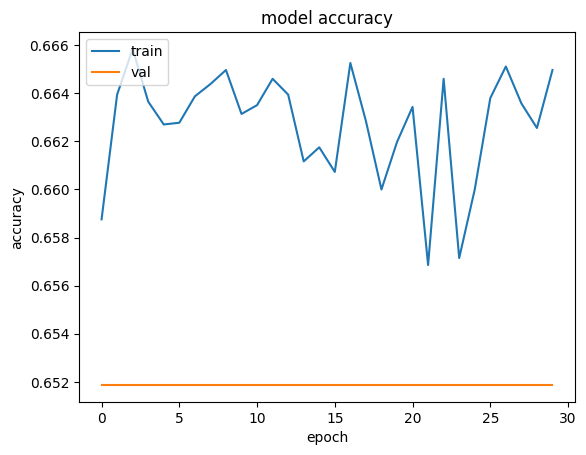

In [133]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [134]:
# cbow_embeddings
weights = np.zeros((len(word2id), 200))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = cbow_embeddings[word2id[word]].reshape(1, -1)


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = cbow_embeddings[word2id[word]].reshape(1, -1)['опрагпллирао']

In [135]:
inputs = tf.keras.layers.Input(shape=(200,))

embeddings = tf.keras.layers.Embedding(input_dim=200, output_dim=len(word2id),
                                       trainable=False,
                                       weights=[weights.T])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [136]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 3s 5ms/step - loss: 0.6598 - accuracy: 0.6556 - val_loss: 0.6532 - val_accuracy: 0.6519
Epoch 2/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6635 - accuracy: 0.6455 - val_loss: 0.6475 - val_accuracy: 0.6519
Epoch 3/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6558 - accuracy: 0.6521 - val_loss: 0.6521 - val_accuracy: 0.6519
Epoch 4/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6640 - accuracy: 0.6449 - val_loss: 0.6864 - val_accuracy: 0.5146
Epoch 5/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6556 - accuracy: 0.6543 - val_loss: 0.6438 - val_accuracy: 0.6519
Epoch 6/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6582 - accuracy: 0.6542 - val_loss: 0.7813 - val_accuracy: 0.3703
Epoch 7/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6631 - accuracy: 0.6453 - val_loss: 0.6526 - val_accuracy: 0.6519
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


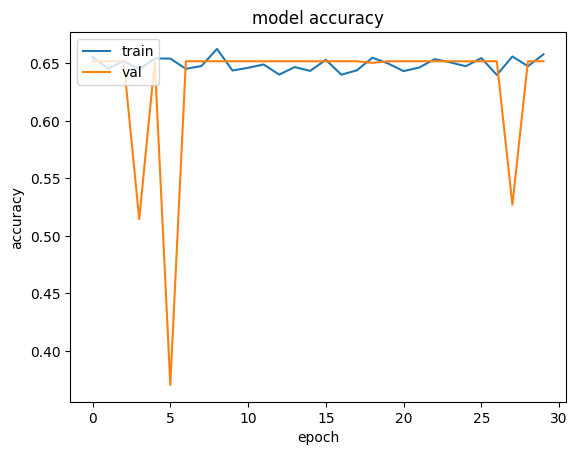

In [137]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Я попробовал транспонировать матрицу в надежде, что это положительно повлияет на графики (они хотя бы не прямые теперь), но все равно по ощущениям это не то..